In [2]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import requests
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [3]:
os.chdir('C:\\Users\\Franco\\Python\\CAF')

In [4]:
distances = pd.read_excel('files/distances.xlsx', index_col = 0)

In [5]:
cwpops = pd.read_excel('files/cwpops.xlsx', index_col = [0,1])

### Acomodar el tema 'Distances' a km

In [6]:
distances['Distance2'] = distances['Distance']

In [7]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [8]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [9]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [10]:
del distances['Distance2']

### Obtengo latitudes y longitudes de las ciudades

In [11]:
latlongs = distances[['Country','City A','Point A']].rename(columns = {'Point A':'latlong','City A':'City'}).drop_duplicates('City').set_index(['Country','City']).dropna()
latlongs[['lat','long']] = latlongs['latlong'].apply(lambda x: pd.Series(x.split(','))).astype(float)
latlongs = latlongs.drop('latlong', axis = 1)

### Joineo con latlongs y creo GeoDataFrame

In [12]:
cwpops = cwpops.join(latlongs)
cwpops = gpd.GeoDataFrame(cwpops, geometry=gpd.points_from_xy(cwpops.long, cwpops.lat))

Creo base cutoff

In [13]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [14]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [15]:
shares_cutoff = pd.DataFrame(index = cwpops.index)

In [16]:
shares_cutoff['index1'] = shares_cutoff.index
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

In [17]:
shares_cutoff = pd.concat([shares_cutoff, shares_cutoff.mean().to_frame(('Promedios','Promedios')).T])

## Generar 'Parsed time in traffic' 

In [18]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [19]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

### Calculo de congestión promedio

Mantengo sólo ciudades que se encuentran a menos de 12 horas de la ciudad objetivo

In [20]:
distances = distances.replace('NAN', np.nan)

In [21]:
cerca = distances.loc[(distances['duration_traffic'] <= 12),:]

Ahora agrego ciudades con masa salarial (% del total del país) mayor a la mediana del país

In [22]:
citywage = pd.DataFrame(cwpops.loc[:,'estimated_citywage'])

a = citywage.groupby('Country').sum('estimated_citywage')
a.rename(columns={'estimated_citywage':'country_wage'},inplace=True)

citywage = a.join(citywage,how='inner')

citywage['wage_ratio'] = citywage['estimated_citywage'] / citywage['country_wage']

citywage.dropna(subset=['wage_ratio'],inplace=True)

In [23]:
a = pd.DataFrame(citywage.loc[:,'wage_ratio'].groupby('Country').median('wage_ratio'))

a.rename(columns={'wage_ratio':'median_wr'},inplace=True)

In [24]:
citywage = a.join(citywage,how='inner')

In [25]:
mercados_target = citywage.loc[(citywage['wage_ratio']>citywage['median_wr']),:]

Ahora filtro mi base de distancias dejando solo los mercados target dentro de las city B

In [26]:
mercados_target.reset_index(inplace=True)
mercados_target.rename(columns={'City':'City B'},inplace=True)
mercados_target.drop(columns=['Country','median_wr','country_wage'],inplace=True)

In [27]:
cerca_mercado = cerca.merge(mercados_target,on='City B', how='inner',validate='m:1',)

In [28]:
cerca_mercado.loc[(cerca_mercado['City A']=='Bahia Blanca-Cerri'),:]

,Country,City A,Point A,City B,Point B,Distance,Duration,Duration in traffic,parsed_duration,distance_km,dit_elementos,duration_traffic,estimated_citywage,wage_ratio
0,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-34.652,-58.547",629.8 km,7 h 31 min,7 hour 20 mins,7.517,629.800,3,7.333,97144424.964,0.495
1,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-37.387311,-68.9227816",704.1 km,8 h 27 min,8 hour 30 mins,8.450,704.100,3,8.500,97144424.964,0.495
30,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Ciudad de Buenos Aires,"-34.6075682,-58.4370894",633.8 km,7 h 36 min,7 hour 10 mins,7.600,633.800,3,7.167,30360769.811,0.155
49,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Cordoba,"-31.381,-64.216",952.1 km,10 h 22 min,11 hour 10 mins,10.367,952.100,3,11.167,8675467.549,0.044
74,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran La Plata,"-34.9206797,-57.9537638",627.7 km,7 h 41 min,7 hour 20 mins,7.683,627.700,3,7.333,1481585.392,0.008
91,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Mar del Plata-Batan,"-37.991,-57.589",459.6 km,5 h 19 min,5 hour 10 mins,5.317,459.600,3,5.167,4604421.163,0.023
106,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Neuquen-Plottier,"-38.943,-68.11",537.7 km,6 h 49 min,6 hour 40 mins,6.817,537.700,3,6.667,2590880.587,0.013
118,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Parana,"-31.7330145,-60.5298511",983.1 km,11 h 43 min,12 hour 0 mins,11.717,983.100,3,12.000,1534617.379,0.008
140,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Rosario,"-32.916,-60.719",759.6 km,9 h 15 min,9 hour 50 mins,9.250,759.600,3,9.833,8235351.758,0.042
165,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Santa Fe,"-31.617,-60.728",924.7 km,10 h 59 min,11 hour 50 mins,10.983,924.700,3,11.833,2535845.937,0.013


In [29]:
cerca_mercado['kms_hora'] = cerca_mercado['distance_km'] / cerca_mercado['duration_traffic']

Ahora tengo que crear las distancias x hora recorridas promedio de cada ciudad para 3 6 9 y 12 horas max

In [36]:
cm = pd.DataFrame(np.nan ,index = cerca_mercado.index.unique(),columns=['dist_3horas','dist_6horas','dist_9horas','dist_12horas'])

In [37]:
mylist = [3,6,9,12]

cerca_mercado = cerca_mercado.rename(columns={'City A':'City'}).set_index(['Country','City'])

KeyError: "None of ['Country', 'City'] are in the columns"

In [32]:
#Cerca mercado es la base de distances en la que las ciudades destino estan a menos de 12 horas 
#y corresponden a masas salariares superiores a la mediana del pais

In [33]:
cerca_mercado.query('(Country == "Argentina" and City == "Bahia Blanca-Cerri") and duration_traffic <= 9').loc[:,'kms_hora'].mean()

85.39326914282047

In [39]:
for i,r in cm.iterrows():
    p = cerca_mercado.loc[i,:]
    for e in mylist:
        cm.loc[i,'dist_{}horas'.format(e)] = p.loc[(p['duration_traffic'] <= e),'kms_hora'].mean()

### Armo ciudades intermedias

In [40]:
pob = cwpops.drop(cwpops.columns[12:], axis=1)

In [41]:
q25 = pd.DataFrame(pob.groupby(['Country'])['pops'].quantile(.25))
q75 = pd.DataFrame(pob.groupby(['Country'])['pops'].quantile(.75))

In [42]:
pob = pob.join(q25 , how ='inner' , rsuffix = '_q25')

In [43]:
pob = pob.join(q75 , how ='inner' , rsuffix = '_q75')

In [44]:
intermedias = pob.loc[((pob['pops'] >= pob['pops_q25']) & (pob['pops'] <= pob['pops_q75'])),]

In [45]:
intermedias = intermedias.drop(list(intermedias.columns[4:9]) + list(intermedias.columns[-3:]),axis=1)

In [46]:
selection = cm.join(intermedias,how='inner')

In [47]:
stack = pd.DataFrame(selection.iloc[:,:4].reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['kms_por_hora'])

In [48]:
stack = stack.reset_index().set_index(['Country','City'])
stack.rename(columns={'level_2':'dist'},inplace=True)

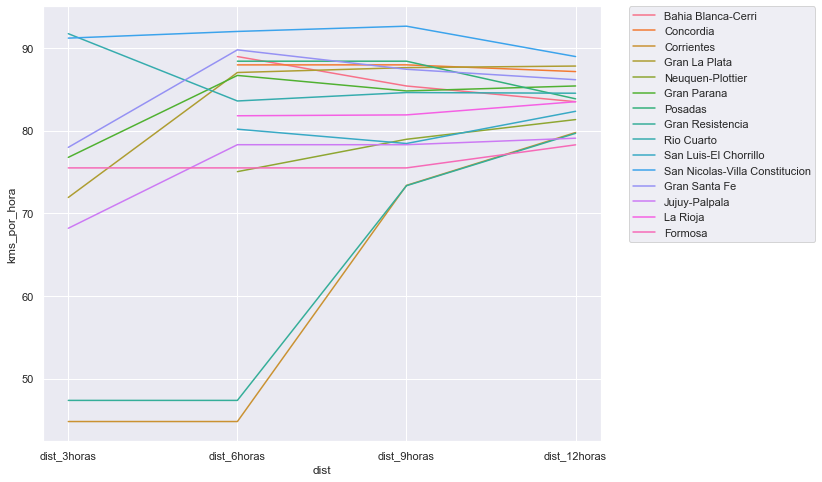

In [49]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=stack.loc['Argentina'], x="dist", y="kms_por_hora" , hue = 'City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

FileNotFoundError: [Errno 2] No such file or directory: 'Entregables/Indicadores/images/Colombia.jpg'

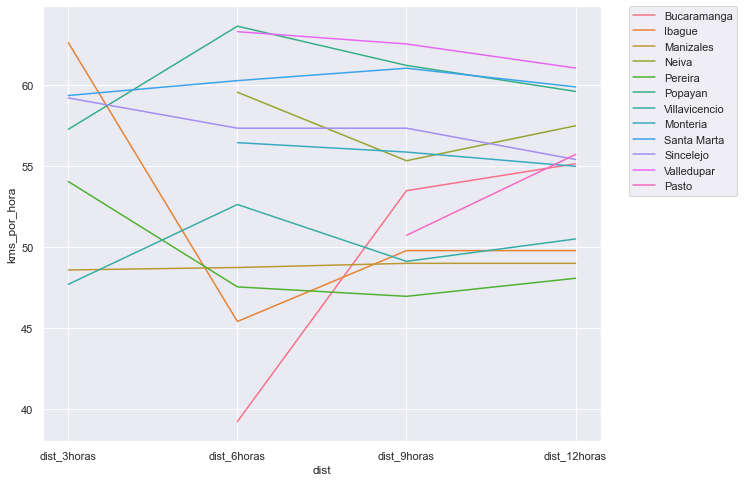

In [50]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=stack.loc['Colombia'], x="dist", y="kms_por_hora" , hue = 'City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Entregables/Indicadores/images/Colombia.jpg")

In [ ]:
selection.loc['Colombia']

In [ ]:
selection.query('(Country == "Argentina" and dist_3horas == "Nan")')

### exporto tablas en html

In [ ]:
mydict={}
mylist = list(selection.reset_index()['Country'].unique())

for i in mylist:
    mydict['{}'.format(i)] = ''

In [ ]:
mydict

In [ ]:
str_io = io.StringIO()

selection.iloc[:,:5].to_html(buf=str_io ,justify='center' ,decimal=',' ,classes='table table-striped')

html_str = str_io.getvalue()

print(html_str)

## Empezamos entonces con la selección

Diccionario para sectores

In [51]:
dic = dic = pd.read_excel('files/Diccionario.xlsx',header=1,usecols='B',nrows=10)

In [52]:
dic.columns = ['actividad']

dic['sn'] = 's' + dic['actividad'].str[:2]

dic['sn'] = dic['sn'].str.replace(" ","")

dic['actividad'] = dic['actividad'].str[5:]

dic = dic.rename(columns={'sn':'principal_sector'})

Ciudades para las que tengo varios indicadores de actividad económica

In [53]:
ejd = pd.read_excel('files/analisis_ejd.xlsx',  sheet_name='Sheet1 (2)')

In [54]:
ejd = ejd.rename(columns={'Pais':'Country','Ciudad':'City'})

In [55]:
#Creo DICT para poder cambiar las siglas de los paises por los nomrbes de los paises

a = list(ejd.loc[:,'Country'].unique())

b = [
 'Brasil',
 'Costa Rica',
 'Argentina',
 'Paraguay',
 'Uruguay',
 'Mexico',
 'Peru',
 'Ecuador',
 'Bolivia',
 'Panama',
 'Venezuela',
 'Chile',
 'Colombia']

b = sorted(b)

nombres = dict(zip(a, b))

nombres['PER'] = 'Peru'
nombres['PRY'] = 'Paraguay'

In [56]:
ejd = ejd.replace({"Country": nombres}).set_index(['Country','City'])

### Selection con join ejd para tener las que poseo data de sectores

In [57]:
selectione = selection.join(ejd,how='inner')

In [58]:
selec_stack = pd.DataFrame(selectione.iloc[:,:4].reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['kms_por_hora'])

In [59]:
selec_stack = selec_stack.reset_index().set_index(['Country','City'])
selec_stack.rename(columns={'level_2':'dist'},inplace=True)

### Armado cutoffs para ciudades que poseen centro de consumo cerca

In [60]:
s = shares_cutoff.drop('index1',axis=1)

In [61]:
for i in range(1,10):
    s['gr_{}'.format(i)] = s['cutoff_{}'.format(i)] - s['cutoff_{}'.format(i-1)]

In [62]:
s.drop(s.columns[0:10], axis=1 , inplace=True)

In [63]:
s['high'] = s.max(axis=1)

In [64]:
# j es la selección de ciudades que tienen saltos de masa salarial en menos de 9 horas
j = pd.DataFrame(s['high'].loc[(s['high'] > .3)])

In [65]:
j = j.join(intermedias.iloc[:,:2], how='inner')

In [66]:
j = j.join(ejd, how='inner')

## Filtro shares_cutoff dejando solo las ciudadades intermedias

In [67]:
sc = shares_cutoff.join(intermedias.iloc[:,:2], how='inner')
sc = sc.loc[(sc['cutoff_9'] < 0.5),list(sc.columns)[1:-2]]

In [68]:
sc = sc.join(ejd, how='inner')

In [69]:
sc_stack = pd.DataFrame(sc.reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['cutoff'])
sc_stack = sc_stack.reset_index().set_index(['Country','City'])
sc_stack.columns = ['hours' , 'cutoff']

### Argentina

cantidad de ciudades intermedias

In [70]:
selection.loc['Argentina'].shape

(15, 10)

Ciudades que se encuentran lejos de los mercados 

In [71]:
sca = sc.reset_index()
sca = sca.loc[(sca['Country']=='Argentina'),:]

In [75]:
sc_stack.head()

hours cutoff
Country   City                                          
Argentina Comodoro Rivadavia-Rada Tilly  cutoff_0  0.012
          Comodoro Rivadavia-Rada Tilly  cutoff_1  0.012
          Comodoro Rivadavia-Rada Tilly  cutoff_2  0.012
          Comodoro Rivadavia-Rada Tilly  cutoff_3  0.012
          Comodoro Rivadavia-Rada Tilly  cutoff_4  0.012

DataError: No numeric types to aggregate

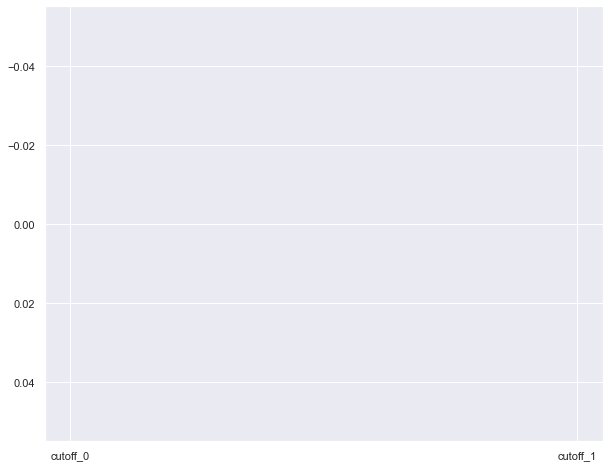

In [76]:
x = sc_stack.loc['Argentina']

sns.set_style("ticks")
sns.despine()
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=x, x="hours", y="cutoff" , hue = 'City').set_title('Gráfico 1: Ciudades que no presentan grandes urbes cercanas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig("Entregables/Indicadores/Argentina/old/lejanas.png",bbox_inches='tight')

In [ ]:
sca1 = sca.set_index(['Country','City']).sort_values('cutoff_9').iloc[:,10:]

In [ ]:
sca1 = sca1.reset_index().merge(dic,on='principal_sector',validate='m:1')

sca1 = sca1.set_index(['Country','City']).drop(columns=['principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre'])

sca1 = sca1.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector'})

cols = sca1.columns.tolist()

cols = [cols[-1]] + cols[:-1]

sca1 = sca1[cols]

In [104]:
tab = sca1.join(cwpops.loc[:,['avg_wg','pops']] ,how='inner').rename(columns={'avg_wg':'salario promedio (usd/hr)','pops':'población estimada'})

In [117]:
tab.to_html(buf="Entregables/Indicadores/Argentina/lejanas.html"  ,decimal=',' , justify='left' ,classes='table table-striped')

In [68]:
#str_io = io.StringIO()

#selection.iloc[:,:5].to_html(buf=str_io ,justify='center' ,decimal=',' ,classes='table table-striped')

#html_str = str_io.getvalue()

#print(html_str)

Ciudades que poseen centro grande en menos de 9 horas

In [77]:
ja = j.loc['Argentina']

In [78]:
scja = shares_cutoff.drop(columns=['index1']).join(ja,how='inner')

In [79]:
scja = scja.iloc[:,:10]

In [80]:
scja_stack = pd.DataFrame(scja.stack(dropna=False) , columns=['cutoff'])

In [81]:
scja_stack = scja_stack.reset_index().set_index(['Country','City']).rename(columns={'level_2':'hours'})

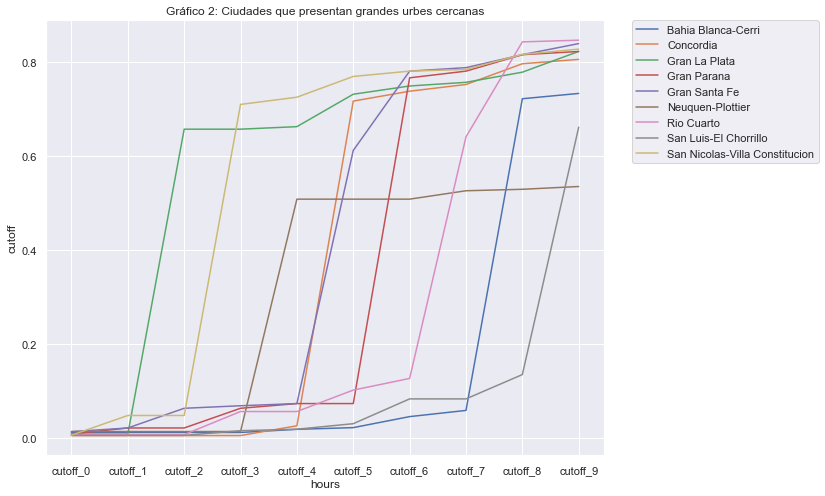

In [83]:
x = scja_stack

sns.set_style("ticks")
sns.set_style("white")
sns.despine()
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=x, x="hours", y="cutoff" , hue = 'City').set_title('Gráfico 2: Ciudades que presentan grandes urbes cercanas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig("Entregables/Indicadores/Argentina/old/cercanas.png",bbox_inches='tight')

In [110]:
scja1 = scja.iloc[[0,3,4,5],:1]

In [111]:
scja1 = scja1.join(ejd,how='inner').iloc[:,1:]

In [112]:
scja1 = pd.concat([scja1, pd.DataFrame(ejd.loc[('Argentina','Gran Mendoza'),:]).T])

In [113]:
scja1 = scja1.reset_index().merge(dic,on='principal_sector',validate='m:1')

scja1 = scja1.set_index(['Country','City']).drop(columns=['principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre'])

scja1 = scja1.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector'})

cols = scja1.columns.tolist()

cols = [cols[-1]] + cols[:-1]

scja1 = scja1[cols]

In [114]:
scja1 = scja1.join(cwpops.loc[:,['avg_wg','pops']] ,how='inner').rename(columns={'avg_wg':'salario promedio (usd/hr)','pops':'población estimada'})

In [116]:
scja1.to_html(buf="Entregables/Indicadores/Argentina/cercanas.html" ,decimal=',' , justify='left' ,classes='table table-striped')

ciudades que parecieran tener congestión en distancias intermedias

In [371]:
cong_arg = selectione.loc['Argentina']

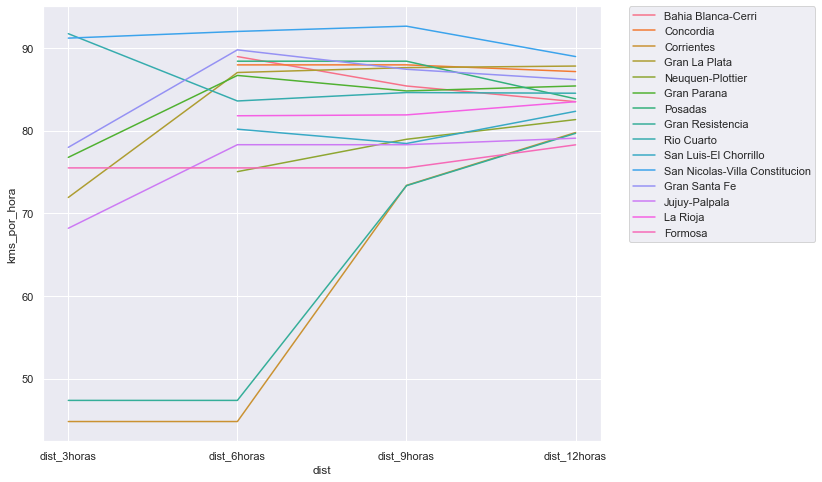

In [517]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style('ticks')
sns.despine()
sns.lineplot(data=selec_stack.loc['Argentina'], x="dist", y="kms_por_hora" , hue = 'City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Entregables/Indicadores/Argentina/old/congestion.png",bbox_inches='tight')

### Brasil

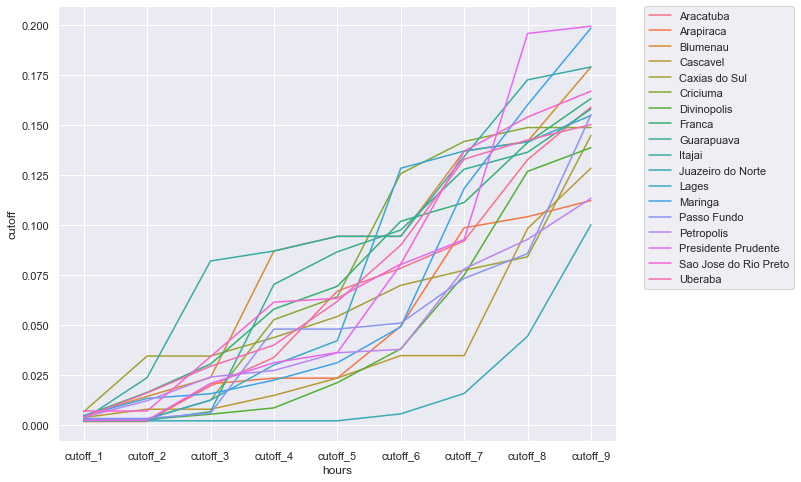

In [207]:
#scb = sc.loc[((sc['cutoff_9'] > 0.1)&(sc['cutoff_9'] < 0.2)),list(sc.columns)[1:]]

#scb_stack = pd.DataFrame(scb.reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['cutoff'])
#scb_stack = scb_stack.reset_index().set_index(['Country','City'])
#scb_stack.columns = ['hours' , 'cutoff']

#x = scb_stack.loc['Brasil']

#sns.set(rc={'figure.figsize':(10,8)})
#sns.lineplot(data=x, x="hours", y="cutoff" , hue = 'City')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
#plt.savefig("Entregables/Indicadores/Brasil/lejanas.png")

Ciudades que se encuentran lejos de los centros de consumo

In [168]:
ri = cwpops.reset_index()
br = ri.loc[(ri['Country']=='Brasil'),:].set_index(['Country','City']) #.quantile(.90)

In [285]:
brint = br.loc[(br['pops']<1400000),['estimated_hourly_wage_US','pops']].sort_values('pops',ascending=False).iloc[:20,].join(shares_cutoff.drop(columns=['index1']),how='inner')

In [286]:
br_ale = brint.loc[(brint['cutoff_9']<0.1),:].sort_values('cutoff_9')

In [287]:
bralestack = pd.DataFrame(br_ale.drop(columns=['estimated_hourly_wage_US','pops']).reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['cutoff'])
bralestack = bralestack.reset_index().set_index(['Country','City'])
bralestack.columns = ['hours' , 'cutoff']

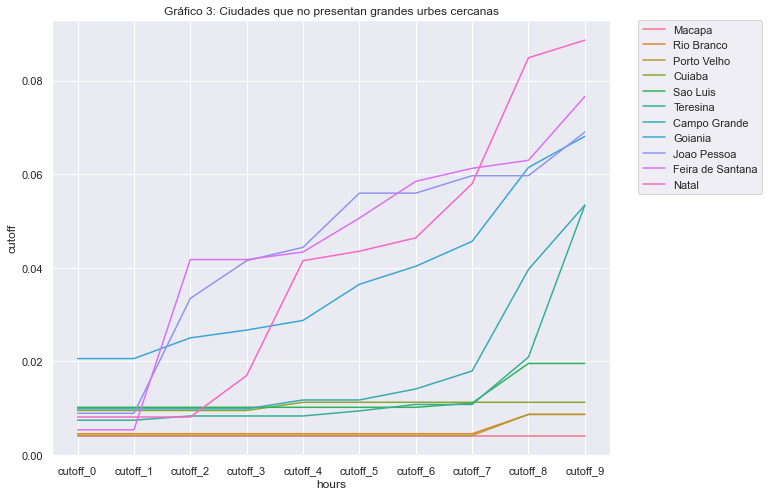

In [288]:
x = bralestack

sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=x, x="hours", y="cutoff" , hue = 'City').set_title('Gráfico 3: Ciudades que no presentan grandes urbes cercanas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig("Entregables/Indicadores/Brasil/lejanas.png",bbox_inches='tight')

In [289]:
brale_tab = br_ale.iloc[:,:2].join(ejd, how='inner')

In [290]:
brale_tab = brale_tab.reset_index().merge(dic,on='principal_sector',validate='m:1')

In [291]:
brale_tab = brale_tab.set_index(['Country','City']).drop(columns=['principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre']).rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})


In [292]:
cols = brale_tab.columns.tolist()

cols = [cols[-1]] + cols[2:-1] + cols[:2]

brale_tab = brale_tab[cols]

In [301]:
brale_tab.to_html(buf="Entregables/Indicadores/Brasil/lejanas.html"  ,decimal=',' , justify='left' ,classes='table table-striped')

#### Ciudades que se encuentran cerca de los centros de consumo

In [257]:
brint2 = br.loc[(br['pops']<1500000),['estimated_hourly_wage_US','pops']].sort_values('pops',ascending=False).iloc[:30,].join(shares_cutoff.drop(columns=['index1']),how='inner')

In [258]:
br_cerca = brint2.iloc[:,2:]

Aplico calculos para saltos en cutoff

In [259]:
for i in range(1,10):
    br_cerca['gr_{}'.format(i)] = br_cerca['cutoff_{}'.format(i)] - br_cerca['cutoff_{}'.format(i-1)]

In [260]:
br_cerca.drop(br_cerca.columns[0:10], axis=1 , inplace=True)

In [261]:
br_cerca['high'] = s.max(axis=1)

In [262]:
br_cerca = pd.DataFrame(br_cerca['high'].loc[(br_cerca['high'] > .05)])

In [263]:
breca_stack = pd.DataFrame(brint2.iloc[:,2:].loc[br_cerca.index].stack(dropna=False) , columns=['cutoff']).reset_index().set_index(['Country','City']).rename(columns={'level_2':'hours'})

In [1]:
x = breca_stack

sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("ticks")
sns.despine()
sns.lineplot(data=x, x="hours", y="cutoff" , hue = 'City').set_title('Gráfico 4: Ciudades que presentan grandes urbes cercanas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig("Entregables/Indicadores/Brasil/old/cercanas.png",bbox_inches='tight')

NameError: name 'breca_stack' is not defined

In [295]:
breca_tab = br_cerca.join(ejd, how='inner')

In [296]:
breca_tab = breca_tab.reset_index().merge(dic,on='principal_sector',validate='m:1')

In [297]:
breca_tab = breca_tab.set_index(['Country','City']).drop(columns=['principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre']).rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [298]:
cols = breca_tab.columns.tolist()

cols = [cols[-1]] + cols[2:-1] + cols[:2]

breca_tab = breca_tab[cols]

In [300]:
breca_tab.to_html(buf="Entregables/Indicadores/Brasil/cercanas.html"  ,decimal=',' , justify='left' ,classes='table table-striped')

### Ciudades que poseen problemas de congestión

In [288]:
#Agrego info de sector economico
#scb = sc.loc['Brasil'].join(ejd, how='inner')

In [326]:
cmrs = cm.reset_index() 
cmbr = cmrs.loc[(cmrs['Country']=='Brasil'),:].set_index(['Country','City'])
brint3 = br.loc[(br['pops']<1400000)&(br['pops']>400000),['estimated_hourly_wage_US','pops']].sort_values('pops',ascending=False).iloc[:35,]

In [353]:
cong_br = cmbr.join(brint3,how='inner').dropna().sort_values('dist_3horas').iloc[:9,:-2]

In [355]:
congbr_stack = pd.DataFrame(cong_br.stack(dropna=False)).reset_index().set_index(['Country','City']).rename(columns={'level_2':'dist',0:'kms_por_hora'})

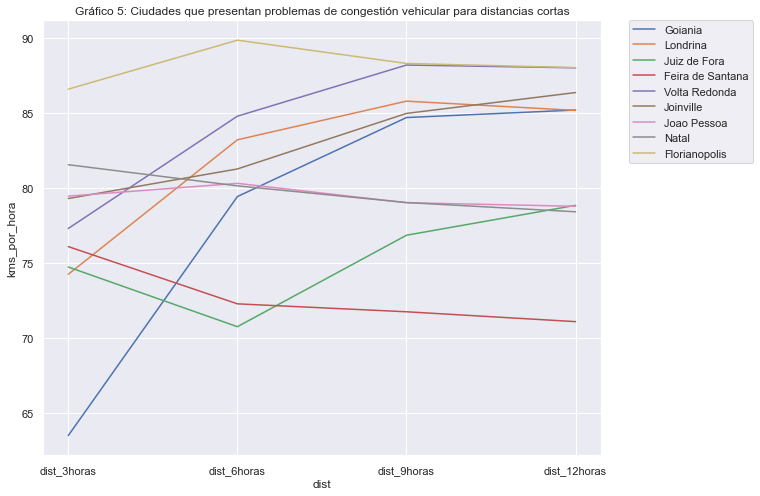

In [356]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=congbr_stack, x="dist", y="kms_por_hora" , hue = 'City').set_title('Gráfico 5: Ciudades que presentan problemas de congestión vehicular para distancias cortas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Entregables/Indicadores/Brasil/congestion.png",bbox_inches='tight')

In [365]:
congbra_tab = cwpops.loc[cong_br.index.tolist(),['estimated_hourly_wage_US','pops']].join(ejd, how='inner').reset_index().merge(dic,on='principal_sector',validate='m:1')

In [367]:
congbra_tab = congbra_tab.set_index(['Country','City']).drop(columns=['principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre']).rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [369]:
cols = congbra_tab.columns.tolist()

cols = [cols[-1]] + cols[2:-1] + cols[:2]

congbra_tab = congbra_tab[cols]

In [371]:
congbra_tab.to_html(buf="Entregables/Indicadores/Brasil/congestion.html"  ,decimal=',' , justify='left' ,classes='table table-striped')